In [1]:
import torch
import os
import torch.nn as nn
from torch.nn import functional as F 
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

batch_size = 64
num_epochs = 10


transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = 'D:\zzStudies\CSE499\ASL\Datasets\Dataset 1 - Image - Keggle'
image_dataset = datasets.ImageFolder(data_dir+ "/asl_alphabet_train/asl_alphabet_train", transforms)

print(image_dataset.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [2]:
print(len(image_dataset))

87000


In [3]:
val_size = 13000
test_size = 13000
train_size = len(image_dataset) - val_size - test_size
batch_size =64
train_ds, val_ds, test_ds = random_split(image_dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

61000 13000 13000


In [4]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()
device

device(type='cuda')

In [6]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda() # add this line
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda() # add this line
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [8]:
class BasicBlock(nn.Module):

    def __init__(self, ch_in, ch_out, stride=1):

        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ch_out)

        if stride !=1 or ch_in != ch_out:
            self.downsample = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
            ) 
        else:
            self.downsample = nn.Sequential()

    def forward(self, inputs):

        x = self.relu(self.bn1(self.conv1(inputs)))
        x = self.bn2(self.conv2(x))
        inputs = self.downsample(inputs)
        x = F.relu(x+inputs)

        return x


In [9]:
def build_layer(self, ch_in, ch_out, num_Block, stride=1):

        layers = []
        layers.append(BasicBlock(ch_in, ch_out, stride))

        for _ in range(1, num_Block):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))

        return nn.Sequential(*layers)

In [10]:
class ResNet18(ImageClassificationBase):

    def __init__(self):
        
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.build_layer(64, 64, 2, 1)
        self.layer2 = self.build_layer(64, 128, 2, 2)
        self.layer3 = self.build_layer(128, 256, 2, 2)
        self.layer4 = self.build_layer(256, 512, 2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(512, 29, bias=True)

    def forward(self, x):

        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x).view(x.size(0), -1)
        x = self.fc(x)

        return x
	
	#Same as above
    def build_layer(self, ch_in, ch_out, num_Block, stride=1):

        layers = []
        layers.append(BasicBlock(ch_in, ch_out, stride))

        for _ in range(1, num_Block):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))

        return nn.Sequential(*layers)

In [11]:
model = to_device(ResNet18(),device)
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

In [12]:
input_tensor = torch.randn(1, 3, 64, 64).to(device)
output_tensor = model(input_tensor)
print(output_tensor.shape)

torch.Size([1, 29])


In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, lr, model, train_loader, val_loader, grad_clip, opt_func, momentum):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), lr, momentum)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [14]:
history = [evaluate(model, val_dl)]
history

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:21<00:00,  4.81it/s]


[{'val_loss': 3.367953062057495, 'val_acc': 0.03504561260342598}]

In [15]:
epochs = 3
lr = 0.01
grad_clip = 0.1
momentum = 0.9
opt_func = torch.optim.SGD

In [16]:
history += fit_one_cycle(epochs, lr, model, train_dl, val_dl, grad_clip, opt_func, momentum)

  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00994, train_loss: 0.7618, val_loss: 0.0927, val_acc: 0.9656


  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00463, train_loss: 0.0156, val_loss: 0.0030, val_acc: 0.9997


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:19<00:00,  5.21it/s]

Epoch [2], last_lr: 0.00000, train_loss: 0.0015, val_loss: 0.0010, val_acc: 0.9998


In [17]:
epochs = 7
lr = 0.001

In [18]:
history += fit_one_cycle(epochs, lr, model, train_dl, val_dl, grad_clip, opt_func, momentum)

  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00048, train_loss: 0.0010, val_loss: 0.0007, val_acc: 0.9999


  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00099, train_loss: 0.0009, val_loss: 0.0009, val_acc: 0.9998


  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00092, train_loss: 0.0009, val_loss: 0.0007, val_acc: 0.9999


  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00067, train_loss: 0.0008, val_loss: 0.0007, val_acc: 0.9999


  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00036, train_loss: 0.0008, val_loss: 0.0007, val_acc: 0.9998


  0%|                                                                                          | 0/954 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00010, train_loss: 0.0007, val_loss: 0.0007, val_acc: 0.9999


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:21<00:00,  4.83it/s]

Epoch [6], last_lr: 0.00000, train_loss: 0.0007, val_loss: 0.0007, val_acc: 0.9999


In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

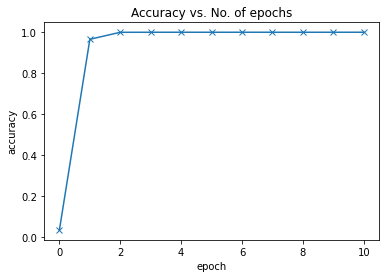

In [20]:
plot_accuracies(history)

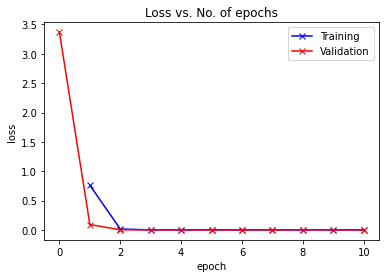

In [21]:
plot_losses(history)

In [22]:
torch.save(model.state_dict(), 'resnet18.pth')